In [40]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [32]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    cat = ['PULocationID', 'DOLocationID']
    num = ['trip_distance']
    
    df[cat] = df[cat].astype(str)
    
    df['DO_PU'] = df['PULocationID'] + '_' + df['DOLocationID']
    
    return df

In [33]:
df_train = read_dataframe('data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('data/green_tripdata_2021-02.parquet')

In [34]:
df_train.shape, df_val.shape

((73908, 22), (61921, 22))

In [35]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,DO_PU
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,NaN,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,NaN,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,NaN,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,NaN,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.96,0.0,NaN,0.3,5.76,1.0,1.0,0.00,2.316667,75_75


In [36]:
cat = ['DO_PU']
num = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[cat + num].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[cat + num].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [37]:
target = 'duration'

y_train = df_train[target].values
y_val = df_val[target].values

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_val)

mean_squared_error(lr_pred, y_val, squared=False)

7.758715207820828

/tmp/ipykernel_2001/1436350820.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lr_pred, label='prediction')
/tmp/ipykernel_2001/1436350820.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='actual')


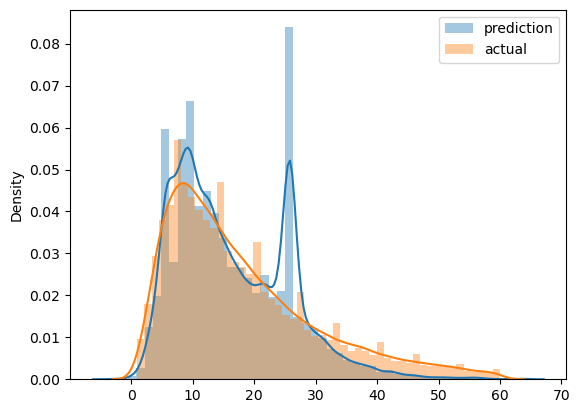

In [39]:
sns.distplot(lr_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()

In [42]:
with open('models/lr.bin', 'wb') as file:
    pickle.dump((dv, lr), file)